# Recommendation Systems Assignment

### MIE451/1513 UofT

## Imports

In [1]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

## Support functions and variables

In [2]:
#!unzip ml-100k.zip -d .

Archive:  ml-100k.zip
replace ./ml-100k/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
MOVIELENS_DIR = "ml-100k"

In [3]:
!ls {MOVIELENS_DIR}

README
allbut.pl
mku.sh
u.data
u.genre
u.info
u.item
u.occupation
u.user
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [7]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. row IDs are (userID-1), columns IDs are (itemID-1),
            and the rating for (userID,itemID,rating) is the value at this row and column.  
            Any observed ratings are zero.
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
              
    """
    matrix = np.zeros((num_users, num_items))
    ########### your code goes here ###########
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [8]:
dataPreprocessor(rating_df, num_users, num_items)

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

### (b)

In [9]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'  
            
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # Extract the items the user already rated
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            predictionMatrix[user, item] = itemPopularity[item]

        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")

In [10]:
popularity_recsys = BaseLineRecSys('popularity')

In [11]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [12]:
popularity_recsys.getModel()

array([[ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ]])

In [13]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [02:27, 678.18it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [15]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [16]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [17]:
average_user_rating_recsys.getModel()

array([[ 3.61029412,  3.61029412,  3.61029412, ...,  3.61029412,
         3.61029412,  3.61029412],
       [ 3.70967742,  3.70967742,  3.70967742, ...,  3.70967742,
         3.70967742,  3.70967742],
       [ 2.7962963 ,  2.7962963 ,  2.7962963 , ...,  2.7962963 ,
         2.7962963 ,  2.7962963 ],
       ..., 
       [ 4.04545455,  4.04545455,  4.04545455, ...,  4.04545455,
         4.04545455,  4.04545455],
       [ 4.26582278,  4.26582278,  4.26582278, ...,  4.26582278,
         4.26582278,  4.26582278],
       [ 3.41071429,  3.41071429,  3.41071429, ...,  3.41071429,
         3.41071429,  3.41071429]])

In [18]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [04:00, 416.43it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [19]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the euclidean similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
            
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the somethingelse similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
                
                self.__model: this is the same dimensions and row/column IDs as train_matrix, 
                but anywhere there is a 0 in train_matrix, there should be a predicted value 
                in self.__model.
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see 'vectorizedUserSimRecSys' code in for an efficient vectorized example)
                
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = 1 - pairwise_distances(train_matrix.T, metric='cosine')
            normalizer = np.matmul(temp_matrix, ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            tt_model = np.matmul(train_matrix, ii_similarity)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(tt_model, axis=0)
            tt_model[:, columns==0] = tt_model[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = tt_model
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [20]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [21]:
SimBasedRecSys.euclidean(I)

array([[ 1.        ,  0.41421356,  0.41421356],
       [ 0.41421356,  1.        ,  0.41421356],
       [ 0.41421356,  0.41421356,  1.        ]])

In [22]:
SimBasedRecSys.somethingelse(I)

array([[ 1.        ,  0.33333333,  0.33333333],
       [ 0.33333333,  1.        ,  0.33333333],
       [ 0.33333333,  0.33333333,  1.        ]])

### (b)

Manhattan distance place less emphasis on outliers, and it may work better than the Euclidean distance for high dimensional vectors.

## Q3

### (a)

In [23]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [24]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [25]:
user_cosine_recsys.getModel()

array([[ 3.89911175,  3.19022667,  3.0261129 , ...,  2.        ,
         3.        ,  3.        ],
       [ 3.84034456,  3.17139889,  2.92626717, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.87104065,  3.12823798,  3.03250708, ...,  2.        ,
         3.        ,  3.        ],
       ..., 
       [ 3.90754645,  3.20227238,  3.05776201, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91100649,  3.21591021,  2.98854017, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91593122,  3.24268207,  3.08255897, ...,  0.        ,
         3.        ,  3.        ]])

In [26]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:146: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [01:20, 1236.92it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [28]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = len([item for item in topK if item in userTestVector])/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return sumPrecisions/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = len([item for item in topK if item in userTestVector])/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return sumRecalls/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return foldsgetData
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
            scores[algorithm.getPredColName()] = fold_scores
            
        results = scores    
    
        return results

In [29]:
# How to use CrossValidation Class?

In [30]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [31]:
# user-user and item-item based collaborative filtering for cosine similarity
algorithm_instances = [item_cosine_recsys,
                       user_cosine_recsys]

In [32]:
# report RMSE results 
cv_rmse = CrossValidation('RMSE')

In [33]:
scores = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:146: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:14, 1353.07it/s]
20000it [00:12, 1645.25it/s]
20000it [00:11, 1722.76it/s]
20000it [00:11, 1770.41it/s]
20000it [00:11, 1770.35it/s]


Processing algorithm user-cosine


20000it [00:11, 1727.31it/s]
20000it [00:10, 1844.37it/s]
20000it [00:11, 1810.48it/s]
20000it [00:10, 1828.59it/s]
20000it [00:11, 1775.34it/s]


In [34]:
import scipy.stats as stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    mu,sd = np.mean(a),np.std(a)
    z = stats.t.ppf(confidence, n)
    h=z*sd/sqrt(n)
    return mu, h

In [35]:
for key, value in scores.items():
    print("{}:".format(key))
    print(mean_confidence_interval(value, confidence=0.95))

user-cosine:
(1.0173541216605808, 0.0054145411296886384)
item-cosine:
(1.0152091203759024, 0.0089555621545861185)


The item-item collaborative filtering have lower rmse, but user-user have smaller CI, so it is hard to tell which is better.

Considering the average number of ratings, since our data has more items than users, each user tends to have more ratings than each item. User-User model is better because:

1. With more ratings per user, a user's average rating usually doesn't change quickly and model is more stable.

2. With more items than users, computing similarities between all pairs of items is expensive.

## Q4

### (a)

In [36]:
all_algorithm_insta = [popularity_recsys, 
                       average_user_rating_recsys, 
                       item_cosine_recsys,
                       user_cosine_recsys]
cv_rmse = CrossValidation('RMSE')
cv_pk = CrossValidation('P@K')
cv_rk = CrossValidation('R@K')

In [37]:
scores_rmse = cv_rmse.run(all_algorithm_insta, num_users, num_items,k=5)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:11, 1679.81it/s]
20000it [00:11, 1792.74it/s]
20000it [00:12, 1638.94it/s]
20000it [00:12, 1594.04it/s]
20000it [00:15, 1316.90it/s]


Processing algorithm useraverage


20000it [00:09, 2022.14it/s]
20000it [00:10, 1879.38it/s]
20000it [00:11, 1675.41it/s]
20000it [00:11, 1797.80it/s]
20000it [00:11, 1719.36it/s]


Processing algorithm item-cosine


20000it [00:10, 1916.04it/s]
20000it [00:10, 1975.19it/s]
20000it [00:10, 1831.10it/s]
20000it [00:11, 1772.77it/s]
20000it [00:10, 1876.76it/s]


Processing algorithm user-cosine


20000it [00:10, 1945.21it/s]
20000it [00:11, 1677.53it/s]
20000it [00:11, 1812.89it/s]
20000it [00:11, 1743.83it/s]
20000it [00:11, 1815.56it/s]


In [40]:
scores_pk = cv_pk.run(all_algorithm_insta, num_users, num_items,k=5)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:13, 1520.21it/s]
20000it [00:13, 1476.37it/s]
20000it [00:11, 1785.24it/s]
20000it [00:10, 1820.79it/s]
20000it [00:11, 1810.49it/s]


Processing algorithm useraverage


20000it [00:10, 1844.40it/s]
20000it [00:10, 1831.20it/s]
20000it [00:11, 1815.62it/s]
20000it [00:11, 1679.81it/s]
20000it [00:11, 1729.75it/s]


Processing algorithm item-cosine


20000it [00:10, 1844.40it/s]
20000it [00:11, 1782.77it/s]
20000it [00:11, 1668.87it/s]
20000it [00:11, 1741.52it/s]
20000it [00:11, 1772.86it/s]


Processing algorithm user-cosine


20000it [00:11, 1815.37it/s]
20000it [00:11, 1753.21it/s]
20000it [00:11, 1817.97it/s]
20000it [00:11, 1722.44it/s]
20000it [00:10, 1890.50it/s]


In [38]:
scores_rk = cv_rk.run(all_algorithm_insta, num_users, num_items,k=5)

Processing algorithm popularity


0it [00:00, ?it/s]C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:17, 1117.91it/s]
20000it [00:15, 1273.62it/s]
20000it [00:19, 1015.70it/s]
20000it [00:12, 1634.75it/s]
20000it [00:11, 1734.43it/s]


Processing algorithm useraverage


20000it [00:10, 1844.40it/s]
20000it [00:11, 1770.42it/s]
20000it [00:11, 1777.80it/s]
20000it [00:11, 1797.78it/s]
20000it [00:10, 1876.86it/s]


Processing algorithm item-cosine


20000it [00:10, 1863.19it/s]
20000it [00:10, 1871.37it/s]
20000it [00:10, 1894.31it/s]
20000it [00:10, 1844.43it/s]
20000it [00:10, 1825.98it/s]


Processing algorithm user-cosine


20000it [00:10, 1855.10it/s]
20000it [00:10, 1825.98it/s]
20000it [00:10, 1876.86it/s]
20000it [00:11, 1813.01it/s]
20000it [00:10, 1904.78it/s]


In [41]:
data_matrix = [['recommenders', 'RMSE_mean', 'RMSE_ci', 'P@K_mean', 'P@K_ci', 'R@K_mean', 'R@K_ci'],
               ['popularity', 
                mean_confidence_interval(scores_rmse["popularity"], confidence=0.95)[0], mean_confidence_interval(scores_rmse["popularity"], confidence=0.95)[1], 
                mean_confidence_interval(scores_pk["popularity"], confidence=0.95)[0], mean_confidence_interval(scores_pk["popularity"], confidence=0.95)[1], 
                mean_confidence_interval(scores_rk["popularity"], confidence=0.95)[0], mean_confidence_interval(scores_rk["popularity"], confidence=0.95)[1]],
               ['user_average', 
                 mean_confidence_interval(scores_rmse["useraverage"], confidence=0.95)[0], mean_confidence_interval(scores_rmse["useraverage"], confidence=0.95)[1],
                 mean_confidence_interval(scores_pk["useraverage"], confidence=0.95)[0], mean_confidence_interval(scores_pk["useraverage"], confidence=0.95)[1], 
                 mean_confidence_interval(scores_rk["useraverage"], confidence=0.95)[0], mean_confidence_interval(scores_rk["useraverage"], confidence=0.95)[1]],
               ['item_cosine', 
                 mean_confidence_interval(scores_rmse["item-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_rmse["item-cosine"], confidence=0.95)[1], 
                 mean_confidence_interval(scores_pk["item-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_pk["item-cosine"], confidence=0.95)[1], 
                 mean_confidence_interval(scores_rk["item-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_rk["item-cosine"], confidence=0.95)[1]],
               ['user_cosine', 
                mean_confidence_interval(scores_rmse["user-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_rmse["user-cosine"], confidence=0.95)[1],
                mean_confidence_interval(scores_pk["user-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_pk["user-cosine"], confidence=0.95)[1], 
                mean_confidence_interval(scores_rk["user-cosine"], confidence=0.95)[0], mean_confidence_interval(scores_rk["user-cosine"], confidence=0.95)[1]]]

In [42]:
print(pd.DataFrame(data_matrix))

              0          1           2         3          4         5  \
0  recommenders  RMSE_mean     RMSE_ci  P@K_mean     P@K_ci  R@K_mean   
1    popularity    3.15909   0.0128532  0.550583  0.0942182  0.484076   
2  user_average    1.04372   0.0095991  0.473637  0.0854521  0.441323   
3   item_cosine    1.01521  0.00895556  0.532216  0.0964082  0.474971   
4   user_cosine    1.01735  0.00541454  0.555843  0.0949339  0.486269   

           6  
0     R@K_ci  
1    0.07591  
2  0.0727126  
3  0.0788048  
4  0.0758339  


### (b)

Useraverage baseline can't be evaluate by p@k or R@k.
Popularity baseline can't be evaluate by rmse.

### (c)

For RMSE, item-item-cosine recommender has lowest mean RMSE, but user-user-cosine recommender is the best considering average number of ratings per user is larger.

For P@5, user-user-cosine recommender is the best with largest precision.

For R@5, user-user-cosine recommender is the best with largest recall.

### (d)

Not necessarily, RMSE does not measure highly ranked items differently than lower ranked items.

## Q5

### (a)

In [43]:
trai_matrix = dataPreprocessor(rating_df, num_users, num_items)
trai_matrix = trai_matrix.T
ii_pred = 1 - pairwise_distances(trai_matrix, metric='cosine')

In [44]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
def itemTopK(prediction, moviesDataset, itemID, k):
    # Pick top K based on predicted rating
    itemVector = prediction[:,itemID-1]
    topK = nlargest(k+1, range(len(itemVector)), itemVector.take)
    topK = topK[1:]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

688 Leave It to Beaver 

369 Black Sheep 

219 Nightmare on Elm Street

In [47]:
itemTopK(ii_pred, moviesDF, 688, 5)

['Steel (1997)',
 'Excess Baggage (1997)',
 'Wishmaster (1997)',
 'I Know What You Did Last Summer (1997)',
 'Anna Karenina (1997)']

In [48]:
itemTopK(ii_pred, moviesDF, 369, 5)

['Beverly Hills Ninja (1997)',
 'Happy Gilmore (1996)',
 'Nutty Professor, The (1996)',
 'Cable Guy, The (1996)',
 'Kingpin (1996)']

In [49]:
itemTopK(ii_pred, moviesDF, 219, 5)

['Candyman (1992)',
 'Interview with the Vampire (1994)',
 'American Werewolf in London, An (1981)',
 'Carrie (1976)',
 'Cape Fear (1991)']

### (b)

The movies from the same genre tend to be recommend. The reason may be that users have preference for movies and they often give similar scores for similar movies.

## Q6 [GRAD ONLY]

### (a)

In [50]:
matrixqsix = dataPreprocessor(rating_df, num_users, num_items)
row = (matrixqsix!= 0).sum(1)

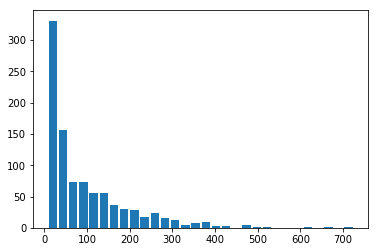

In [54]:
import matplotlib.pyplot as plt
hist = np.histogram(row, bins=30)
plt.bar(hist[1][:30], hist[0], width = 20)
plt.show()

In [66]:
train_set = getData(MOVIELENS_DIR, 'u{0}.base'.format(1))
train_set = train_set.loc[train_set['userID'].isin(train_set.groupby('userID').count().itemID > 40)]

In [68]:
train_set.groupby('userID').count().itemID > 40

userID
1    True
Name: itemID, dtype: bool

In [67]:
train_set.shape

(135, 4)

In [ ]:
folds = []
data_types = ['u{0}.base','u{0}.test']
for i in range(1,6):
    train_set = getData(MOVIELENS_DIR, data_types[0].format(i))
    
    test_set = getData(MOVIELENS_DIR, data_types[1].format(i))
    folds.append([train_set, test_set])
return foldsgetData

In [ ]:
 def runqsix(folds, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
            scores[algorithm.getPredColName()] = fold_scores
            
        results = scores    
    
        return results

# Validation

In [34]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [35]:
def testDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [36]:
validation_df = testDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [37]:
def testPopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [38]:
testPopularityRecSys()

### User Average Based Recommendation

In [39]:
def testUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [40]:
testPopularityRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [41]:
def testEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [42]:
testEuclidean()

### Customized Similarity Function (test somethingelse function)

In [43]:
def testCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [44]:
testCustomizedSim()

### User-User Similarity Based Recommendation System

In [45]:
def testUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [46]:
testUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [47]:
def testIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [48]:
testIISimBasedRecSys()